In [31]:
import os
import pickle as pkl
import csv
import math
import pandas as pd
import numpy as np

from kmapper import KeplerMapper, Cover
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

WDIRS = [    
    'results/seedrun_m1-2022-01-16/run_seed1394398/evaluation_0/',
    'results/seedrun_m1-2022-01-16/run_seed1394398/continue_1/continue_1/continue_2/continue_2/continue_2/evaluation_1/',
    'results/20220129-EVOL_b5-goodseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/evaluation_1/',
    'results/seedrun_m1-2022-01-16/run_seed5397326/evaluation_0/',
    'results/seedrun_m1-2022-01-16/run_seed5397326/continue_1/continue_1/continue_2/continue_2/continue_2/evaluation_50/',
    'results/20220128-EVOL_b5-badseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/evaluation_2/',
]

NAMES = ['INIT-S6', 'STDP-S6', 'EVOL-S6', 'INIT-S3', 'STDP-S3', 'EVOL-S3']

GET_ONLY = 1
if GET_ONLY != None:
    WDIRS = WDIRS[GET_ONLY:GET_ONLY+1]
    NAMES = NAMES[GET_ONLY:GET_ONLY+1]

# WDIRS = [
#     '/Users/danielhasegan/workspace/netpyne-project/results/evol-stdp-rl/evaluation_40/',]

# NAMES = ['EVOL-STDP-RL']


# wdir= '/Users/danielhasegan/workspace/netpyne-project/results/20210907-ES1500it/evaluation_0/'
# wdir= '/Users/danielhasegan/workspace/netpyne-project/results/20210907-ES1500it/evaluation_15/'
# wdir= '/Users/danielhasegan/workspace/netpyne-project/results/hpsearch-2021-09-06/best/1_run_168/evaluation_8/'

LENSES = []


resolution = 49.8 / 4
offset = 49.8 * 3
N = 10000 # total_length // 5

for wdir in WDIRS:
    print(wdir)

    sim_path = os.path.join('../', wdir, 'sim.pkl')

    with open(sim_path, 'rb') as f:
        sim = pkl.load(f)

    total_length = math.ceil((sim['simData']['spkt'][-1] - offset) / resolution)
    num_gids = int(max(sim['simData']['spkid']) + 1)
#     N = 10000 # total_length // 5
    M = num_gids

    X = np.zeros((N, M), dtype=np.short)

    for spkt, spkid in zip(sim['simData']['spkt'], sim['simData']['spkid']):
        if spkt < offset:
            continue

        t = math.floor((spkt - offset) / resolution)
        if t >= N:
            continue
        X[t][int(spkid)] = 1

    # Generate shape graph using KeplerMapper
    mapper = KeplerMapper(verbose=1)
    lens = mapper.fit_transform(X, projection=TSNE(2, perplexity=20, random_state=1))

    LENSES.append(lens)

results/seedrun_m1-2022-01-16/run_seed1394398/continue_1/continue_1/continue_2/continue_2/continue_2/evaluation_1/
KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: TSNE(perplexity=20, random_state=1)
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (10000, 200)

..Projecting data using: 
	TSNE(perplexity=20, random_state=1, verbose=1)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.886s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 1

In [ ]:

[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.854675
[t-SNE] KL divergence after 1000 iterations: 2.159042

In [32]:
MOT_OUTS = []


for wdir in WDIRS:
    mot_path = os.path.join('../', wdir, 'MotorOutputs.txt')
    
    with open(mot_path) as f:
        mot_rews = [line for line in csv.reader(f, delimiter='\t')]

    y = np.zeros(N, dtype=np.short)

    for idx, row in enumerate(mot_rews):
        if float(row[0]) < offset:
            continue
        tstart = math.floor((float(row[0]) - offset) / resolution)

        if idx < len(mot_rews) - 1:
            tnext = math.floor((float(mot_rews[idx+1][0]) - offset) / resolution)
        else:
            tnext = N

        lmove, rmove = float(row[1]), float(row[2])
        move = 1 if lmove == rmove else (2 if lmove > rmove else 3)

        for t in range(tstart, tnext):
            if t >= N:
                continue
            y[t] = move
            
    MOT_OUTS.append(y)

STDP-S6


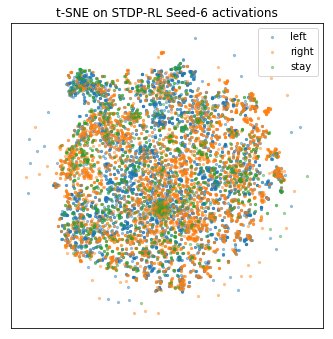

In [33]:
import matplotlib.pyplot as plt


for wdir, name, lens, y in zip(WDIRS, NAMES, LENSES, MOT_OUTS):
    print(name)

    S = 5
    plt.figure(figsize=(5,5))

    L = []

    for i in [2,3,1]:
        plt.scatter(lens[y == i][:,0], lens[y == i][:,1], 5, alpha=0.4)
        L.append(['stay', 'left', 'right'][i-1])

    plt.title('t-SNE on {} activations'.format(name.replace('-S', ' Seed-').replace('STDP', 'STDP-RL')))
    plt.tight_layout()

    plt.legend(L)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('tSNE-{}.png'.format(name.lower()), dpi=300)

## Below is deprecated

In [ ]:
import matplotlib
matplotlib.rcParams['font.family']


In [ ]:
ACTS_EPS = []

# EPS_INTERVALS = [
#     [0, 20],
#     [20, 30],
#     [30, 40],
#     [40, 60],
#     [60, 100],
#     [100, 150],
#     [150, 200],
#     [200, 300],
#     [300, 501]]

EPS_INTERVALS = [
    [0, 50],
    [50, 100],
    [100, 200],
    [200, 501]]


for wdir in WDIRS:
    acts_path = os.path.join(wdir, 'ActionsPerEpisode.txt')
    
    with open(acts_path) as f:
        acts = [int(float(line[1])) for line in csv.reader(f, delimiter='\t')]

    y = np.zeros(N, dtype=np.short)
    
    current_eps = 0
    for idx, eps in enumerate(acts):
        interval_idx = [i for i,(s,e) in enumerate(EPS_INTERVALS) if s <= eps and eps < e][0]
        
        tstart = current_eps
        tend = tstart + eps  + (-3 if idx == 0 else 0)

        for t in range(tstart, tnext):
            if t >= N:
                continue
            y[t] = interval_idx
            
        current_eps = tend
            
    ACTS_EPS.append(y)

In [ ]:
for wdir, name, lens, y in zip(WDIRS, NAMES, LENSES, ACTS_EPS):
    print(name)

    plt.figure(figsize=(10,10))

    L = []

    for i,(s,e) in enumerate(EPS_INTERVALS):
        plt.scatter(lens[y == i][:,0], lens[y == i][:,1], 5, alpha=0.7)
        L.append('Acts per Eps in [{},{})'.format(s,e))

    plt.title('t-SNE on {} activations'.format(name))
    plt.tight_layout()

    plt.legend(L)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('tSNE_actseps-{}.png'.format(name.lower()), dpi=300)

In [ ]:
import matplotlib.pyplot as plt

d = np.sum((lens[1:] - lens[:-1]) ** 2, axis=1)

plt.hist(d)

In [ ]:
graph = mapper.map(lens, X, cover=Cover(10, 0.8), clusterer=DBSCAN(eps=10.0))

In [ ]:
from dyneusr import DyNeuGraph

# Visualize the shape graph using DyNeuSR's DyNeuGraph                          
dG = DyNeuGraph(G=graph, y=y)
dG.visualize('dyneusr_stdp_p50.html')


In [ ]:
from dyneusr.tools import visualize_mapper_stages

fig, axes = visualize_mapper_stages(
    X, y=y, lens=lens, graph=graph, cover=mapper.cover,
    node_size=20, edge_size=0.5, edge_color='gray',
    layout="kamada_kawai",  figsize=(16, 4)
    )

plt.savefig('tSNE-stdp.png', dpi=300)
plt.show()

In [ ]:
lens[y == 1][:,0]